In [1]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import re
import time
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Retrive data and exploring

In [2]:
! ls ../data

IMDB-Dataset-SPANISH.csv  data-info.txt


In [3]:
df = pd.read_csv('../data/IMDB-Dataset-SPANISH.csv')
df.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


In [4]:
df.columns

Index(['Unnamed: 0', 'review_en', 'review_es', 'sentiment', 'sentimiento'], dtype='object')

In [5]:
def count_words(st):
    return len(re.split("[^a-zA-Z0-9]", st))

count_words("Esta es una buena pelicula, la mejor.")

9

In [6]:
def get_data_and_clean():
    # get data
    df = pd.read_csv('../data/IMDB-Dataset-SPANISH.csv')
    
    # delete not translated data
    # Due to there are some review_es that are not translated to spanish
    df["review_en_norm"] = df.review_en.apply(lambda x : ''.join(e for e in x if e.isalnum())).apply(lambda x : x.upper())
    df["review_es_norm"] = df.review_es.apply(lambda x : ''.join(e for e in x if e.isalnum())).apply(lambda x : x.upper())

    df = df.query("review_en_norm != review_es_norm")

    # corrections
    df = df[["review_es","sentimiento"]]
    df = df.rename(columns={"review_es": "review", "sentimiento": "target"})

    # over summary
    df.review = df.review.apply(lambda x : x.upper())
    
    # over target
    df.target = df.target.apply(lambda x : 1 if x == "positivo" else 0)
    
    return df

In [7]:
df_train = get_data_and_clean()
df_train.head()

,review,target
0,UNO DE LOS OTROS CRÍTICOS HA MENCIONADO QUE DE...,1
1,UNA PEQUEÑA PEQUEÑA PRODUCCIÓN.LA TÉCNICA DE F...,1
2,PENSÉ QUE ESTA ERA UNA MANERA MARAVILLOSA DE P...,1
3,"BÁSICAMENTE, HAY UNA FAMILIA DONDE UN NIÑO PEQ...",0
4,"EL ""AMOR EN EL TIEMPO"" DE PETTER MATTEI ES UNA...",1


In [8]:
df_train.isna().sum()

review    0
target    0
dtype: int64

In [9]:
df_train['target'].value_counts()

0    24133
1    24050
Name: target, dtype: int64

MAX: 1369
MIN: 11


<AxesSubplot: ylabel='Frequency'>

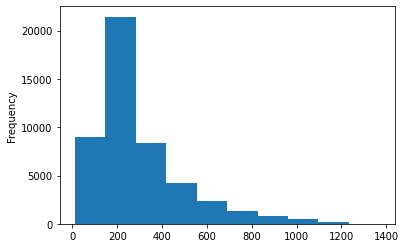

In [10]:
count_words = df_train.review.apply(count_words)
print(f"MAX: {count_words.max()}")
print(f"MIN: {count_words.min()}")
count_words.plot.hist()

In [11]:
df_train.to_csv("../data/train.csv")

# Model

In [12]:
# Initialize
RANDOM_SEED = 42
MAX_LEN = 300
BATCH_SIZE = 16
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
# TOKENIZE
# https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
sample_txt = "es muy buena"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Phrase: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Tokens ids: {token_ids}')

Phrase: es muy buena
Tokens: ['es', 'muy', 'buena']
Tokens ids: [1058, 1456, 2667]


In [15]:
samples = df_train.sample(5).review
sample_df = pd.DataFrame()
sample_df['text'] = samples.to_list()
sample_df['tokens'] = sample_df.text.apply(lambda x : tokenizer.tokenize(x))

sample_df

,text,tokens
0,"LA PELÍCULA EN SÍ ES ABSOLUTAMENTE BRILLANTE, ...","[LA, PEL, ##Í, ##CUL, ##A, EN, S, ##Í, ES, AB,..."
1,"HAMLET ES, DE LEJOS, MI FAVORITA DE TODAS LAS ...","[HA, ##M, ##LE, ##T, ES, ,, DE, LE, ##J, ##OS,..."
2,"BARBARA STANWYCK COMO UNA VERDADERA GALLETA, U...","[BAR, ##BA, ##RA, ST, ##AN, ##W, ##Y, ##C, ##K..."
3,TRES SARGENTOS EN EL EJÉRCITO BRITÁNICO ESTACI...,"[TR, ##ES, SA, ##R, ##GE, ##N, ##TOS, EN, EL, ..."
4,"UN CADETE DEL EJÉRCITO EGOCÉNTRICO, LLEGA A WE...","[UN, CAD, ##ET, ##E, DEL, E, ##J, ##É, ##RC, #..."


In [16]:
# Prepare input for BERT 
encoding_tmp = tokenizer.encode_plus(
    sample_txt,
    max_length = 20,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [17]:
encoding_tmp

{'input_ids': tensor([[   4, 1058, 1456, 2667,    5,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [18]:
print(tokenizer.convert_ids_to_tokens(encoding_tmp.input_ids[0]))

['[CLS]', 'es', 'muy', 'buena', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [19]:
# DATASET

class ReviewsDataset(Dataset):

    def __init__(self, reviews, target, tokenizer, max_len):
        self.reviews = reviews
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.target[item]

        encoding = tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            truncation = True,
            add_special_tokens = True,
            return_token_type_ids = False,
            padding = 'max_length',
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'review': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [20]:
# DATA LOADER

def data_loader(df, tokenizer, max_len, batch_size):

    dataset = ReviewsDataset(
        reviews = df.review.to_numpy(),
        target = df.target.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(dataset, batch_size=batch_size, num_workers=4)

In [40]:
# split data and create data loaders
x_train, x_test = train_test_split(df_train, test_size=0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(x_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(x_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [41]:
# MODEL!

class BETOReviewsClassifier(nn.Module):

    def __init__(self, n_classes):
        super(BETOReviewsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        cls_output = bert_output[1] # passing the pooler_output/token classification
        t = self.drop(cls_output)
        t = self.relu(t)
        t = self.fc(t)
        output = self.softmax(t)

        return output

In [23]:
model = BETOReviewsClassifier(NCLASSES)
model = model.to(device)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

In [ ]:
# print(model)

In [42]:
# Training setting

EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [43]:
# Training and validation iteration functions

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    print("### Training Model ###")
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, total=len(data_loader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target = batch['target'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, target)
        correct_predictions += torch.sum(preds == target)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    print("### Evaluate Model ###")
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, total=len(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['target'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, target)
            correct_predictions += torch.sum(preds == target)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Running Model

In [ ]:
# TRAIN!

start_time = time.time()

for epoch in range(EPOCHS):
    start_batch_time = time.time()

    print(f'Epoch {epoch+1} out of {EPOCHS}')
    print('---------------------------------')
    train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(x_train)
    )
    test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(x_test)
    )
    end_batch_time = time.time()
    process_batch_time = round((end_batch_time - start_batch_time) / 60, 2)

    print(f'Training loss: {train_loss}, accuracy: {train_acc}')
    print(f'Validation loss: {test_loss}, accuracy: {test_acc}')
    print(f'Process batch time: {process_batch_time} minutes.')
    print('')

end_time = time.time()
process_time = round((end_time - start_time) / 60, 2)

print(f'Fitting model with {EPOCHS} epochs took {process_time} minutes.')

Epoch 1 out of 1
---------------------------------
### Training Model ###


  0%|                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

In [ ]:
torch.save(model, '../models/model_test.pth')

# Testin model

In [ ]:
model2 = torch.load('../models/model_test.pth')

In [10]:
target_map = {
    0: "Negativo",
    1: "Positivo"
}

In [11]:
def classify_review(review):
    encoding_review = tokenizer.encode_plus(
    review,
    max_length = MAX_LEN,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors = 'pt'
    )

    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model2(input_ids, attention_mask) # LOADED MODEL!
    prediction = torch.argmax(output.flatten()).item()

    return target_map[prediction]

In [12]:
classify_review("Muy buena pelicula")

'Positivo'